In [3]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.9/316.9 MB 3.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.0-py2.py3-none-any.whl size=317425344 sha256=2739f788d09fabd58b730b73a4bd5cadc6b14a28e2e85de23c0f11e9d5f063c3
  Stored in directory: /root/.cache/pip/wheels/41/4e/10/c2cf2467f71c678cfc8a6b9ac9241e5e44a01940da8fbb17fc
Successfully built pyspark


In [4]:
import pyspark
import os
from pyspark import SparkConf
from pyspark.sql import SparkSession
from pyspark import SparkContext
from pyspark import HiveContext
from pyspark.sql.session import *
from pyspark.sql import *
from pyspark.sql.types import *
from pyspark.sql.window import Window
from pyspark.ml.feature import QuantileDiscretizer, Bucketizer, StringIndexer, IndexToString

import pyspark.sql.functions as F
import pandas as pd
import numpy as np

#import pyarrow
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns


spark = SparkSession.builder.master("local[*]")\
          .appName("NLP_pyspark")\
          .getOrCreate()
sc = spark.sparkContext
sc

<SparkContext master=local[*] appName=NLP_pyspark>

In [5]:
from IPython.display import Image, display, Markdown
from IPython.core.display import HTML
display(HTML('<style = fonte-size>pre {white-space: pre !important; }</style>'))

##**Sequence Embeddings**

Bag of words, count vectorizer, and TF-IDF are different ways to convert text into numerical form. But they don't cosider neither the context nor the sequence order of the words, which matter a lot for understanding any text data.

That’s where embeddings
can shine and provide a robust mechanism to understand and represent text data in a
numerical form. Sequence embedding is a powerful way that offers us the flexibility to not only
compare any two individual string chains, but also use them to predict the probability of a given event in the context of the problem studied.

Embeddings are unique in terms of capturing the context of the words
and representing it in such a way that words with similar meanings are represented with
a similar sort of embeddings. There are two ways to calculate the embeddings:
1. Skip gram
2. Continuous bag of words (CBOW)

On
a high level, both the methods give the embedding values that are the weights of the
hidden layer in a neural network. The embedding vector size can be chosen based on
a requirement, but a size of 100 works well for most of the cases. We will make use of
word2vec in Spark to create embeddings.










In [6]:
%%time

df = spark.read.parquet('embedding_dataset.parquet')

print('Total rows: ', df.count())
display(df.show(5))

Total rows:  1696825
+----------+------------+---------+------------------+---------+
|   user_id|        page|timestamp|        time_spent|Converted|
+----------+------------+---------+------------------+---------+
|0000000001|product info|       10|1.7691465155918633|      1.0|
|0000000001|product info|        8|1.5045683893412218|      1.0|
|0000000001|      others|        2|0.6644732027259945|      1.0|
|0000000001|product info|        7|1.2453834019392749|      1.0|
|0000000001|product info|        4|0.7310627245311483|      1.0|
+----------+------------+---------+------------------+---------+
only showing top 5 rows



None

CPU times: user 133 ms, sys: 14.3 ms, total: 147 ms
Wall time: 23.5 s


In [7]:
%%time
print('No. of users: ',  df.select('user_id').distinct().count())
df.groupBy('page').count().orderBy('count',ascending=False).show(10,False)

No. of users:  96824
+-------------+-------+
|page         |count  |
+-------------+-------+
|product info |1187023|
|homepage     |219978 |
|added to cart|103791 |
|others       |61420  |
|offers       |49283  |
|buy          |38794  |
|reviews      |36536  |
+-------------+-------+

CPU times: user 49.1 ms, sys: 7.09 ms, total: 56.1 ms
Wall time: 7.33 s


The whole idea of sequence embeddings is to translate the series of steps taken
by the user during their online journey into a page sequence that can be used for
calculating embedding scores. The first step is to remove any of the consecutive
duplicate pages during the journey of a user. We create an additional column that
captures the previous page of the user using the window function in PySpark

In [13]:
%%time
df.filter(F.col('user_id')=='0000000001').count()

CPU times: user 4.52 ms, sys: 1.15 ms, total: 5.67 ms
Wall time: 350 ms


15

In [12]:
%%time
w = Window.partitionBy("user_id").orderBy('timestamp')
df = df.withColumn('timestamp', F.col('timestamp').cast(IntegerType()))\
    .withColumn('time_spent', F.col('time_spent').cast(DecimalType(18,16)))\
    .withColumn("previous_page", F.lag("page", 1, 'started').over(w))
df.filter(F.col('user_id')=='0000000001')\
    .select('user_id','timestamp','time_spent','previous_page','page')\
    .sort('timestamp').show(15,False)

+----------+---------+------------------+-------------+------------+
|user_id   |timestamp|time_spent        |previous_page|page        |
+----------+---------+------------------+-------------+------------+
|0000000001|1        |1.1588400331634994|started      |homepage    |
|0000000001|2        |0.6644732027259945|homepage     |others      |
|0000000001|3        |0.1281033525613009|others       |product info|
|0000000001|4        |0.7310627245311483|product info |product info|
|0000000001|5        |0.5723876771577245|product info |product info|
|0000000001|6        |1.1849744062291630|product info |product info|
|0000000001|7        |1.2453834019392749|product info |product info|
|0000000001|8        |1.5045683893412218|product info |product info|
|0000000001|9        |0.0233226911854216|product info |others      |
|0000000001|10       |1.7691465155918633|others       |product info|
|0000000001|11       |1.5611537386977081|product info |product info|
|0000000001|12       |0.3944843791

In [15]:
%%time
#Now, we create a function to check if the current page is like the previous
#page and indicate the same in a new column indicator. indicator_cumulative
#is the column to track the number of distinct pages during the user journey.

@F.udf(returnType=IntegerType())
def indicator(page, prev_page):
  return (1,0)[page == prev_page]

df = df.withColumn("indicator",indicator('page', 'previous_page')) \
        .withColumn('indicator_cummulative',F.sum('indicator').over(w))

df.filter(F.col('user_id')=='0000000001')\
    .select('user_id','previous_page','page','indicator','indicator_cummulative')\
    .show(20,False)

+----------+-------------+------------+---------+---------------------+
|user_id   |previous_page|page        |indicator|indicator_cummulative|
+----------+-------------+------------+---------+---------------------+
|0000000001|started      |homepage    |1        |1                    |
|0000000001|homepage     |others      |1        |2                    |
|0000000001|others       |product info|1        |3                    |
|0000000001|product info |product info|0        |3                    |
|0000000001|product info |product info|0        |3                    |
|0000000001|product info |product info|0        |3                    |
|0000000001|product info |product info|0        |3                    |
|0000000001|product info |product info|0        |3                    |
|0000000001|product info |others      |1        |4                    |
|0000000001|others       |product info|1        |5                    |
|0000000001|product info |product info|0        |5              

In [16]:
%%time
#calculate the aggregated time spent on similar pages so that
#only a single record can be kept for representing consecutive pages

w2 = Window.partitionBy(["user_id",'indicator_cummulative']).orderBy('timestamp')
df = df.withColumn('time_spent_cummulative',F.sum('time_spent').over(w2))
df.filter(F.col('user_id')=='0000000001')\
  .select('timestamp','previous_page','page','indicator',
          'indicator_cummulative','time_spent','time_spent_cummulative')\
  .show(20,False)

+---------+-------------+------------+---------+---------------------+------------------+----------------------+
|timestamp|previous_page|page        |indicator|indicator_cummulative|time_spent        |time_spent_cummulative|
+---------+-------------+------------+---------+---------------------+------------------+----------------------+
|1        |started      |homepage    |1        |1                    |1.1588400331634994|1.1588400331634994    |
|2        |homepage     |others      |1        |2                    |0.6644732027259945|0.6644732027259945    |
|3        |others       |product info|1        |3                    |0.1281033525613009|0.1281033525613009    |
|4        |product info |product info|0        |3                    |0.7310627245311483|0.8591660770924492    |
|5        |product info |product info|0        |3                    |0.5723876771577245|1.4315537542501737    |
|6        |product info |product info|0        |3                    |1.1849744062291630|2.61652

In [18]:
%%time
w3 = Window.partitionBy(["user_id",'indicator_cummulative'])\
     .orderBy(F.col('timestamp').desc())
df = df.withColumn('final_page',F.first('page').over(w3))\
    .withColumn('final_time_spent',F.first('time_spent_cummulative').over(w3))

df.filter(F.col('user_id')=='0000000001')\
  .select(['time_spent_cummulative','indicator_cummulative',
           'page','final_page','final_time_spent'])\
  .show(15,False)

+----------------------+---------------------+------------+------------+------------------+
|time_spent_cummulative|indicator_cummulative|page        |final_page  |final_time_spent  |
+----------------------+---------------------+------------+------------+------------------+
|1.1588400331634994    |1                    |homepage    |homepage    |1.1588400331634994|
|0.6644732027259945    |2                    |others      |others      |0.6644732027259945|
|5.3664799517598334    |3                    |product info|product info|5.3664799517598334|
|3.8619115624186116    |3                    |product info|product info|5.3664799517598334|
|2.6165281604793367    |3                    |product info|product info|5.3664799517598334|
|1.4315537542501737    |3                    |product info|product info|5.3664799517598334|
|0.8591660770924492    |3                    |product info|product info|5.3664799517598334|
|0.1281033525613009    |3                    |product info|product info|5.366479

In [24]:
%%time
aggregations = []
aggregations.append(F.max('final_page').alias('page_emb'))
aggregations.append(F.max('final_time_spent').alias('time_spent_emb'))
aggregations.append(F.max('converted').alias('converted_emb'))

df_embedding = df.select(['user_id','indicator_cummulative',
                          'final_page','final_time_spent','converted'])\
                 .groupBy(['user_id','indicator_cummulative'])\
                 .agg(*aggregations)

df_embedding.filter(F.col('user_id').isin(['0000000001','0000000002'])).toPandas().head(15)

CPU times: user 34.6 ms, sys: 3.72 ms, total: 38.3 ms
Wall time: 1.2 s


,user_id,indicator_cummulative,page_emb,time_spent_emb,converted_emb
0,0000000001,1,homepage,1.1588400331634994,1.0
1,0000000001,2,others,0.6644732027259945,1.0
2,0000000001,3,product info,5.3664799517598334,1.0
3,0000000001,4,others,0.0233226911854216,1.0
4,0000000001,5,product info,5.5885333196814016,1.0
5,0000000002,1,product info,2.1472025512577537,1.0
6,0000000002,2,others,0.2698081802695118,1.0
7,0000000002,3,offers,0.1207348322536725,1.0
8,0000000002,4,product info,0.4640909459992408,1.0


In [25]:
%%time
w4 = Window.partitionBy(["user_id"]).orderBy('indicator_cummulative')
w5 = Window.partitionBy(["user_id"]).orderBy(F.col('indicator_cummulative').desc())

#Now we use collect_list to combine all the pages of the user journey
#into a single list and for time spent as well. As a result, we end with
#a user journey in the form of a page list and time spent list

df_embedding = df_embedding.withColumn('journey_page', F.collect_list('page_emb').over(w4))\
                .withColumn('journey_time_temp', F.collect_list('time_spent_emb').over(w4))\
                .withColumn('journey_page_final',F.first('journey_page').over(w5))\
                .withColumn('journey_time_final',F.first('journey_time_temp').over(w5)) \
                .select(['user_id','journey_page', 'journey_page_final',
                         'journey_time_temp','journey_time_final','converted_emb'])

pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
df_embedding.filter(F.col('user_id').isin(['0000000001','0000000002'])).toPandas().head(15)

CPU times: user 37.7 ms, sys: 9.89 ms, total: 47.6 ms
Wall time: 3.01 s


,user_id,journey_page,journey_page_final,journey_time_temp,journey_time_final,converted_emb
0,0000000001,"[homepage, others, product info, others, product info]","[homepage, others, product info, others, product info]","[1.1588400331634994, 0.6644732027259945, 5.3664799517598334, 0.0233226911854216, 5.5885333196814016]","[1.1588400331634994, 0.6644732027259945, 5.3664799517598334, 0.0233226911854216, 5.5885333196814016]",1.0
1,0000000001,"[homepage, others, product info, others]","[homepage, others, product info, others, product info]","[1.1588400331634994, 0.6644732027259945, 5.3664799517598334, 0.0233226911854216]","[1.1588400331634994, 0.6644732027259945, 5.3664799517598334, 0.0233226911854216, 5.5885333196814016]",1.0
2,0000000001,"[homepage, others, product info]","[homepage, others, product info, others, product info]","[1.1588400331634994, 0.6644732027259945, 5.3664799517598334]","[1.1588400331634994, 0.6644732027259945, 5.3664799517598334, 0.0233226911854216, 5.5885333196814016]",1.0
3,0000000001,"[homepage, others]","[homepage, others, product info, others, product info]","[1.1588400331634994, 0.6644732027259945]","[1.1588400331634994, 0.6644732027259945, 5.3664799517598334, 0.0233226911854216, 5.5885333196814016]",1.0
4,0000000001,[homepage],"[homepage, others, product info, others, product info]",[1.1588400331634994],"[1.1588400331634994, 0.6644732027259945, 5.3664799517598334, 0.0233226911854216, 5.5885333196814016]",1.0
5,0000000002,"[product info, others, offers, product info]","[product info, others, offers, product info]","[2.1472025512577537, 0.2698081802695118, 0.1207348322536725, 0.4640909459992408]","[2.1472025512577537, 0.2698081802695118, 0.1207348322536725, 0.4640909459992408]",1.0
6,0000000002,"[product info, others, offers]","[product info, others, offers, product info]","[2.1472025512577537, 0.2698081802695118, 0.1207348322536725]","[2.1472025512577537, 0.2698081802695118, 0.1207348322536725, 0.4640909459992408]",1.0
7,0000000002,"[product info, others]","[product info, others, offers, product info]","[2.1472025512577537, 0.2698081802695118]","[2.1472025512577537, 0.2698081802695118, 0.1207348322536725, 0.4640909459992408]",1.0
8,0000000002,[product info],"[product info, others, offers, product info]",[2.1472025512577537],"[2.1472025512577537, 0.2698081802695118, 0.1207348322536725, 0.4640909459992408]",1.0


In [30]:
%%time
print('No. of lines (including duplicates): ', df_embedding.count())
df_embedding = df_embedding.select(['user_id', 'journey_page_final',
                                    'journey_time_final','converted_emb'])
df_embedding = df_embedding.dropDuplicates()

#Each user is represented by a single journey and time spent vector
print('No. of lines (dropping duplicates): ', df_embedding.count())
print('total users: ', df_embedding.select('user_id').distinct().count())

df_embedding.select('user_id','journey_page_final','journey_time_final')\
            .limit(5).toPandas().head(5)

No. of lines (including duplicates):  875523
No. of lines (dropping duplicates):  96824
total users:  96824
CPU times: user 368 ms, sys: 39.2 ms, total: 407 ms
Wall time: 2min 12s


,user_id,journey_page_final,journey_time_final
0,0000000001,"[homepage, others, product info, others, product info]","[1.1588400331634994, 0.6644732027259945, 5.3664799517598334, 0.0233226911854216, 5.5885333196814016]"
1,0000000002,"[product info, others, offers, product info]","[2.1472025512577537, 0.2698081802695118, 0.1207348322536725, 0.4640909459992408]"
2,0000000003,"[product info, offers, product info, others]","[1.6526341214641942, 1.8833665995410414, 3.8830717958356752, 0.6594165502097968]"
3,0000000007,"[product info, homepage, product info, reviews, product info, homepage]","[0.1544823217073181, 2.4628009923253205, 1.6413105835225020, 0.7856056080923075, 7.4537130430186529, 1.8178270465174429]"
4,0000000008,"[product info, reviews, product info, others, product info, homepage, product info]","[1.1415054856467830, 0.2452921838571747, 0.2569880712417663, 2.1031914287259497, 5.1950094723036015, 1.0196848034789487, 1.7061964244155730]"


In [34]:
%%time
#We can now move to create embeddings using the word2vec model by feeding it the
#user journey sequence. The embedding size is kept to 100 for this part:
from pyspark.ml.feature import Word2Vec

word2vec = Word2Vec(vectorSize = 100,
                    inputCol = 'journey_page_final', outputCol = 'embedding')
model = word2vec.fit(df_embedding)
result = model.transform(df_embedding)

result.limit(1).toPandas().head(5)

CPU times: user 338 ms, sys: 40 ms, total: 378 ms
Wall time: 1min 59s


,user_id,journey_page_final,journey_time_final,converted_emb,embedding
0,0000000001,"[homepage, others, product info, others, product info]","[1.1588400331634994, 0.6644732027259945, 5.3664799517598334, 0.0233226911854216, 5.5885333196814016]",1.0,"[0.04338303878903389, -0.1198777660727501, 0.09645098447799683, -0.034828376770019535, -0.1410623222589493, 0.0360914446413517, 0.033751912601292136, 0.10759313479065896, 0.01720379963517189, -0.06059589255601168, -0.001516314595937729, -0.02767193764448166, -0.010094423685222864, 0.012800714280456305, -0.010913459956645966, -0.00015665143728256227, 0.05767873674631119, -0.13868190348148346, 0.08708202093839645, -0.009746407717466356, 0.12016451358795166, 0.00956481620669365, -0.07329830024391414, 0.05604078047908843, 0.006611139327287675, -0.10051956330426037, 0.06419808603823185, -0.007524847984313965, -0.06198079437017441, -0.044219848420470956, -0.023556405724957586, 0.05803025178611279, -0.02930897129699588, -0.042232231050729756, -0.014870957285165787, -0.09226510748267175, 0.007196987047791481, -0.06162778213620186, 0.06296778954565525, -0.05519009158015251, -0.0759174332022667, 0.007476577162742615, -0.027876323461532595, 0.006879048794507981, 0.0505545262247324, -0.023686282336711884, -0.0013696014881134035, -0.011433666944503785, -0.03019954711198807, 0.08480616956949234, 0.0297048956155777, 0.020699744671583177, 0.040909925848245626, 0.022882670164108276, 0.02472909688949585, -0.040117947757244116, -0.04385595917701721, -0.004387380182743073, -0.010629673302173615, 0.015351946651935578, -0.016398848220705985, -0.008100518211722375, -0.07145994268357754, 0.0032370947301387787, 0.05210048109292984, 0.0704541727900505, -0.008133484050631523, -0.013528745621442795, 0.023502013087272646, 0.006936662644147874, 0.016295439377427102, -0.10515164807438851, -0.027333423495292664, -0.017688100039958955, 0.061826768517494204, -0.006166535709053279, 0.10314766876399517, -0.01853867303580046, -0.05746877789497376, -0.10395735893398524, -0.002256457135081291, -0.06660700514912606, -0.07587949354201556, -0.05182715877890587, -0.021611014008522035, -0.034702121280133724, 0.080108143389225, 0.052695517987012865, 0.1191868305206299, 0.012468617409467697, -0.0020270664244890213, -0.08935674987733365, 0.11036455743014813, 0.063858862221241, -0.043643194297328596, -0.025040417909622192, 0.0925134837627411, 0.027010863274335863, 0.03854271173477173, -0.08258577287197114]"


In [37]:
%%time
#We can extract embeddings for each page category using getVectors(), but do ensure
#to change the datatype of the embeddings to double as the embeddings’ original format
#is vector in Spark:
from pyspark.ml.functions import vector_to_array

embeddings=model.getVectors()
embeddings.printSchema()
embeddings.show(10)
embeddings=embeddings.withColumn('vector',vector_to_array('vector'))
embeddings.printSchema()
embeddings.show(10)

root
 |-- word: string (nullable = true)
 |-- vector: vector (nullable = true)

+-------------+--------------------+
|         word|              vector|
+-------------+--------------------+
| product info|[0.11084186285734...|
|added to cart|[0.01091845612972...|
|       others|[-0.0125342737883...|
|          buy|[0.03299878165125...|
|       offers|[0.11287318170070...|
|      reviews|[0.09094350039958...|
|     homepage|[0.02030001580715...|
+-------------+--------------------+

root
 |-- word: string (nullable = true)
 |-- vector: array (nullable = false)
 |    |-- element: double (containsNull = false)

+-------------+--------------------+
|         word|              vector|
+-------------+--------------------+
| product info|[0.11084186285734...|
|added to cart|[0.01091845612972...|
|       others|[-0.0125342737883...|
|          buy|[0.03299878165125...|
|       offers|[0.11287318170070...|
|      reviews|[0.09094350039958...|
|     homepage|[0.02030001580715...|
+------------

In [38]:
%%time
#the vocabulary size is 7 because we were dealing with seven page
#categories only. Each of these page categories now can be represented
#with the help of the embedding vector of size 100.
page_categories = embeddings.select('word').distinct().collect()
unique_pages = [i.word for i in page_categories]
print(unique_pages)

['others', 'product info', 'added to cart', 'buy', 'homepage', 'reviews', 'offers']
CPU times: user 11 ms, sys: 0 ns, total: 11 ms
Wall time: 713 ms


In [41]:
%%time

#visualize the embeddings
pd.reset_option('display.max_colwidth')
pd_df_embedding = embeddings.toPandas()
pd_df_embedding.head(10)

CPU times: user 6.99 ms, sys: 0 ns, total: 6.99 ms
Wall time: 14.4 ms


,word,vector
0,product info,"[0.11084186285734177, -0.11471925675868988, 0...."
1,added to cart,"[0.010918456129729748, -0.07578513771295547, 0..."
2,others,"[-0.01253427378833294, -0.1383114606142044, 0...."
3,buy,"[0.03299878165125847, -0.0017438833601772785, ..."
4,offers,"[0.11287318170070648, -0.07964065670967102, 0...."
5,reviews,"[0.09094350039958954, -0.08463552594184875, -0..."
6,homepage,"[0.020300015807151794, -0.09332739561796188, 0..."


In [42]:
%%time
X=pd.DataFrame(pd_df_embedding['vector'].values.tolist())
print(X.shape)
X.head(3)

(7, 100)
CPU times: user 6.32 ms, sys: 0 ns, total: 6.32 ms
Wall time: 12 ms


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99
0,0.110842,-0.114719,0.112857,0.080211,-0.178714,0.052123,0.003511,0.118960,0.124392,-0.047583,0.085588,0.070735,-0.050808,0.002424,-0.037638,0.016889,0.083706,-0.079337,0.065927,-0.093091,0.099353,0.024220,-0.158497,0.079137,0.082889,-0.000655,0.158561,-0.130974,-0.023559,-0.093620,0.017661,0.022012,-0.021390,-0.062179,0.068306,-0.157412,0.054917,-0.189710,0.043930,-0.089850,-0.110325,-0.084002,-0.065654,-0.089633,0.090240,-0.055203,-0.107242,0.066314,-0.070689,0.100357,-0.021721,-0.014169,0.063710,0.188294,0.033351,-0.124714,0.077472,0.030635,0.112489,-0.033251,0.006826,0.066276,-0.176383,0.007033,0.076562,0.088993,-0.100712,-0.128522,-0.049530,-0.058323,-0.036266,-0.088274,-0.051018,-0.075203,0.053848,0.059117,0.131678,-0.092822,-0.095278,-0.249422,-0.024715,-0.103252,0.007288,-0.010604,-0.143889,0.002273,0.081905,0.052809,0.074187,0.072349,0.024375,-0.013482,-0.008009,0.043392,-0.086858,-0.035867,0.090898,0.051867,-0.043393,-0.128965
1,0.010918,-0.075785,0.055469,-0.091706,-0.020126,0.022842,0.010870,0.024567,0.019683,0.019545,0.011533,-0.067544,-0.079961,-0.025428,-0.031786,0.039287,0.018549,-0.078711,0.113268,-0.005249,-0.029183,-0.037954,0.039147,0.048765,-0.021955,-0.058997,-0.008300,0.030230,-0.050104,0.003445,0.051000,-0.017948,-0.043240,-0.025001,0.024886,-0.057276,-0.061844,-0.007954,0.033919,-0.053452,0.010060,0.092875,0.024950,0.093283,0.000541,-0.001275,-0.018808,-0.001632,0.030177,0.021190,0.024891,0.017518,-0.031713,0.002459,0.066057,0.029772,-0.043719,0.030759,-0.015141,0.105287,-0.066703,-0.015369,0.036157,0.005478,0.007855,-0.027589,-0.079662,0.085946,0.038438,-0.004457,0.056017,0.012421,0.022563,-0.026851,0.097417,-0.036509,0.034551,0.058167,0.004812,0.045189,0.019403,-0.014610,-0.095248,0.029368,0.067979,-0.037072,0.076601,0.000408,0.034091,-0.077587,0.079449,-0.079326,0.128402,0.012004,0.054725,-0.047439,0.049419,-0.058192,-0.022172,0.027668
2,-0.012534,-0.138311,0.109618,-0.062921,-0.135169,0.004246,0.104059,0.121222,-0.068983,-0.097173,-0.073866,-0.106097,-0.002309,0.059901,0.059979,0.029490,0.022710,-0.190526,0.100804,0.098627,0.147686,0.006517,-0.002260,0.001356,-0.057059,-0.176608,-0.004591,0.077337,-0.104829,-0.019888,-0.076344,0.112812,-0.055731,0.006356,-0.093013,-0.059129,-0.027116,0.045298,0.103287,0.010770,-0.061347,0.059150,-0.053887,0.084206,-0.008900,-0.045005,0.105199,-0.064679,0.026826,0.077779,0.072473,0.059361,0.034934,-0.090155,0.053295,0.034390,-0.151184,-0.085279,-0.078519,0.031439,-0.017133,-0.078151,-0.001418,0.031692,0.090899,0.067895,0.085909,0.012302,0.070363,0.048842,0.084335,-0.151478,-0.072124,0.078754,0.070200,-0.077186,0.113787,0.053139,-0.031434,0.003654,0.032236,-0.036401,-0.115651,-0.060791,0.036448,-0.019605,0.065368,0.009267,0.151116,0.028829,-0.016186,-0.141726,0.195284,0.067001,-0.020940,0.020541,0.070949,0.029558,0.099486,-0.109246


In [43]:
%%time
#to understand the relation between page categories, we can use
#the dimensionality reduction technique (PCA) and plot the seven page embeddings
#on a two-dimensional space:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca_df = pca.fit_transform(X)
pca_df

CPU times: user 157 ms, sys: 39.2 ms, total: 196 ms
Wall time: 538 ms


array([[ 0.86134561,  0.02123794],
       [-0.04010496, -0.11322889],
       [-0.15640889, -0.26787031],
       [-0.1606052 ,  0.04642144],
       [-0.16636697,  0.39560448],
       [-0.17827556,  0.24463839],
       [-0.15958402, -0.32680305]])

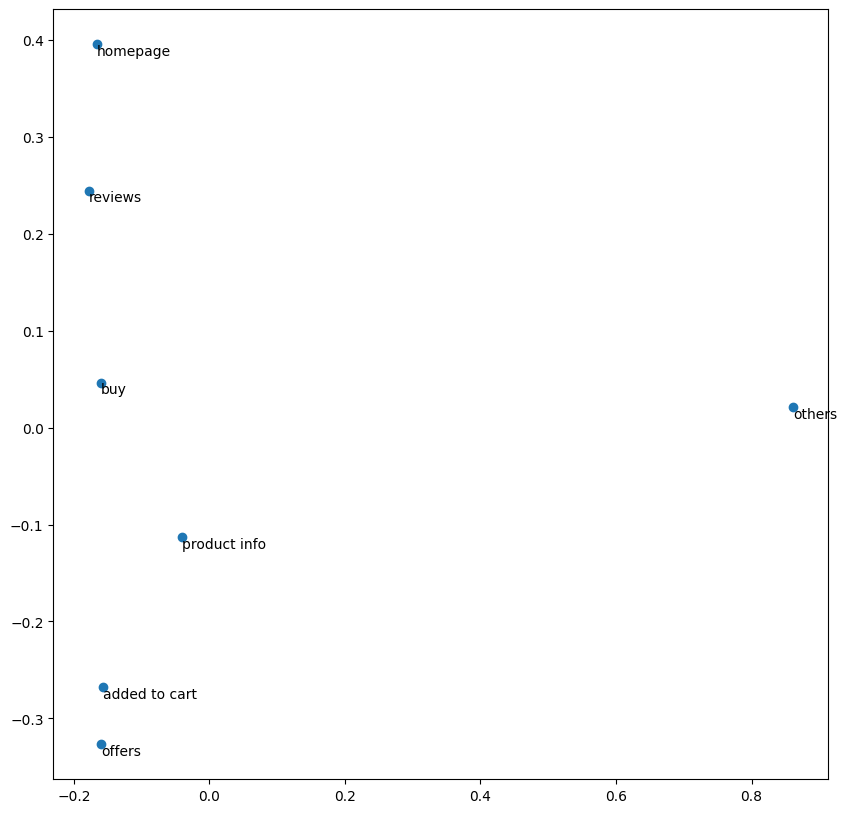

CPU times: user 348 ms, sys: 61.1 ms, total: 410 ms
Wall time: 427 ms


In [45]:
%%time
import matplotlib.pyplot as plt

plt.figure(figsize=(10,10))
plt.scatter(pca_df[:, 0], pca_df[:, 1])
for i,unique_page in enumerate(unique_pages):
  plt.annotate(unique_page,horizontalalignment='left',
               verticalalignment='top',xy=(pca_df[i, 0], pca_df[i, 1]))
plt.show()

#the embeddings of added to cart and offers are near
#to each other in terms of similarity.

#These individual embeddings can be combined
#and used for user journey comparison and classification using Machine Learning.